In [13]:
import torch
import torch.nn as nn
import torchvision
from train_ddgan import sample_from_model, Posterior_Coefficients
import argparse

In [14]:
#torch.cuda.is_available()

In [15]:
from datasets_prep.stackmnist_data import StackedMNIST, _data_transforms_stacked_mnist

In [16]:
train_transform, valid_transform = _data_transforms_stacked_mnist()
train_dataset = StackedMNIST(root='./data', train=True, download=False, transform=train_transform)
val_dataset = StackedMNIST(root='./data', train=False, download=False, transform=valid_transform)

In [17]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [18]:
from torchvision.models import resnet18

In [19]:
device = torch.device("cuda:0")

In [20]:
from torch.utils.data import DataLoader

In [21]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import numpy as np

In [23]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

def train_epoch(model, optimizer, criterion, train_loader, device, tqdm_desc):
    model.train()
    train_acc, train_loss = 0.0, 0.0

    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_acc += (logits.argmax(dim=1) == labels).sum().item()
        train_loss += loss.item() * labels.shape[0]

    train_acc /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    return train_acc, train_loss


@torch.no_grad()
def val_epoch(model, criterion, val_loader, device, tqdm_desc):
    model.eval()
    val_acc, val_loss = 0.0, 0.0

    for images, labels in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        val_acc += (logits.argmax(dim=1) == labels).sum().item()
        val_loss += loss.item() * labels.shape[0]

    val_acc /= len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)

    return val_acc, val_loss


def train(model, optimizer, criterion, scheduler, train_loader, val_loader, device, num_epochs, start_epoch=0):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    for epoch in range(start_epoch + 1, num_epochs + 1):
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_loader, device, f'Training epoch {epoch}/{num_epochs}')
        val_acc, val_loss = val_epoch(model, criterion, val_loader, device, f'Validating epoch {epoch}/{num_epochs}')

        if scheduler is not None:
            scheduler.step(val_loss)
        
        train_losses += [train_loss]
        train_accuracies += [train_acc]
        test_losses += [val_loss]
        test_accuracies += [val_acc]
        
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        #print({'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})

In [24]:
model = resnet18(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 20

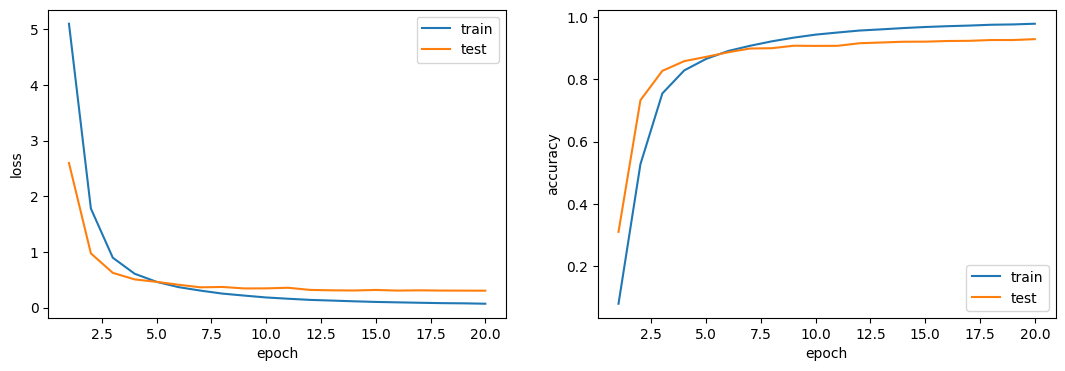

In [14]:
train(model, optimizer, criterion, None, train_loader, val_loader, device, n_epochs)

In [15]:
torch.save(model.state_dict(), "clf.pth")

In [13]:
from argparse import Namespace

In [13]:
model.load_state_dict(torch.load("clf.pth"))

<All keys matched successfully>

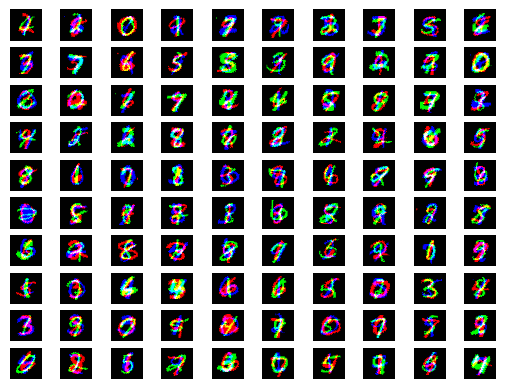

In [25]:
nrows, ncols = 10, 10

for i in range(nrows * ncols):
    img, target = train_dataset[i]
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(T.ToPILImage()(img))
    plt.axis("off")


In [11]:
import pandas as pd